Now, we will use the features generated from EDA and feature engineering to train multiple models:

**XGBoost:** A gradient boosting algorithm that builds an ensemble of decision trees, where each new tree corrects the errors of the previous ones. XGBoost supports GPU-based parallel processing and is highly effective for tabular data.

**Prophet:** A model designed for univariate time series forecasting, particularly well-suited for capturing trend and seasonality.

**LSTM:** A recurrent neural network architecture used to model sequential temporal patterns and long-term seasonal dependencies in time series data.


Each model has its strengths 
- XGBoost for feature-rich predictions,
- Prophet for interpretable seasonality decomposition
- LSTM for complex temporal patterns.

# Step 0: Initialization: Importing and loading libraries

In [25]:
# Core Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing & Clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# XGBoost
import xgboost as xgb

# Prophet
from prophet import Prophet

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reference date for time-based calculations
REFERENCE_DATE = pd.Timestamp("2015-01-01")

Using device: cuda


In [26]:
import kagglehub

# Download latest version
TRAIN_DF_PATH = kagglehub.dataset_download("sachinchaudhary123/rossman-fe")
TRAIN_FILE_NAME = "/train_with_clusters.csv"
 
# Load dataset from feature engineering
train = pd.read_csv(TRAIN_DF_PATH+TRAIN_FILE_NAME, index_col="Date", parse_dates=True)
display(train.head())

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,LogSales,...,IsSchoolHoliday,Sales_Rolling_Mean_7,Sales_Rolling_Mean_14,Sales_Rolling_Mean_28,Sales_Lag_7,Sales_Lag_14,Sales_Lag_21,Sales_Lag_28,Lag_SalePerCustomer_7day,StoreCluster
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,9.482883,8.568646,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-07-31,2,4,6064,625,1,1,0,1,9.702400,8.710290,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-07-31,3,4,8314,821,1,1,0,1,10.126675,9.025816,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-07-31,4,4,13995,1498,1,1,0,1,9.342457,9.546527,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-07-31,5,4,4822,559,1,1,0,1,8.626118,8.481151,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


# Step 1: Feature selection

## XGboost Feature selection

Temporal split is crucial for time series - we cannot use future data to predict the past

One-hot encoding StoreCluster allows XGBoost to learn cluster-specific patterns


In [27]:
xgb_features = [
    # Promotion & Holiday
    "Promo", "IsStateHoliday", "IsSchoolHoliday",
    # Lag Features
    "Sales_Lag_7", "Sales_Lag_14", "Sales_Lag_21", "Sales_Lag_28",
    # Rolling Features
    "Sales_Rolling_Mean_7", "Sales_Rolling_Mean_14", "Sales_Rolling_Mean_28",
    # Store & Time
    "StoreCluster", "Day", "Month", "WeekOfYear"
]

# Create XGBoost dataframe and drop NaN rows
xgb_df = train[xgb_features + ["Sales"]].dropna().copy()

# One-hot encode StoreCluster
xgb_df = pd.get_dummies(xgb_df, columns=["StoreCluster"], drop_first=True)

# Ensure datetime index
xgb_df.index = pd.to_datetime(xgb_df.index)

# Temporal split for time series
SPLIT_DATE = pd.Timestamp("2015-04-01")

xgb_train = xgb_df[xgb_df.index < SPLIT_DATE]
xgb_val = xgb_df[xgb_df.index >= SPLIT_DATE]

# Separate features and target
X_train = xgb_train.drop("Sales", axis=1)
y_train = xgb_train["Sales"]

X_val = xgb_val.drop("Sales", axis=1)
y_val = xgb_val["Sales"]

print("XGBoost Dataset Summary")
print(f"Training samples: {len(X_train):,} (before {SPLIT_DATE.date()})")
print(f"Validation samples: {len(X_val):,} (from {SPLIT_DATE.date()})")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nFeatures: {X_train.columns.tolist()}")

XGBoost Dataset Summary
Training samples: 881,179 (before 2015-04-01)
Validation samples: 104,810 (from 2015-04-01)
Number of features: 16

Features: ['Promo', 'IsStateHoliday', 'IsSchoolHoliday', 'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_21', 'Sales_Lag_28', 'Sales_Rolling_Mean_7', 'Sales_Rolling_Mean_14', 'Sales_Rolling_Mean_28', 'Day', 'Month', 'WeekOfYear', 'StoreCluster_1', 'StoreCluster_2', 'StoreCluster_3']


## Prophet Feature selection

In [28]:
# Ensure index has name
if train.index.name is None:
    train.index.name = "Date"

# Create base Prophet dataframe
prophet_df = train.reset_index()[["Date", "Store", "Sales"]].copy()
prophet_df.columns = ["ds", "Store", "y"]

# Add regressors
regressors = ["Promo", "IsStateHoliday", "IsSchoolHoliday"]
prophet_reg = train.reset_index()[["Date", "Store"] + regressors]
prophet_reg.rename(columns={"Date": "ds"}, inplace=True)

prophet_df = prophet_df.merge(prophet_reg, on=["ds", "Store"], how="left")

# single store modeling
PROPHET_STORE_ID = 1
store_prophet = prophet_df[prophet_df["Store"] == PROPHET_STORE_ID].dropna()

print("Prophet Dataset Summary")
print(f"Store ID: {PROPHET_STORE_ID}")
print(f"Samples: {len(store_prophet):,}")
display(store_prophet.head())

Prophet Dataset Summary
Store ID: 1
Samples: 942


,ds,Store,y,Promo,IsStateHoliday,IsSchoolHoliday
0,2015-07-31,1,5263,1,0,1
1115,2015-07-30,1,5020,1,0,1
2230,2015-07-29,1,4782,1,0,1
3345,2015-07-28,1,5011,1,0,1
4460,2015-07-27,1,6102,1,0,1


## LSTM Feature selection

In [29]:
lstm_features = [
    "Sales", "Promo", "IsStateHoliday",
    "IsSchoolHoliday", "Sales_Lag_7", "Sales_Rolling_Mean_7"
]

# Create a copy for LSTM processing
lstm_df = train.copy()

# Scale features per store (MinMax scaling)
lstm_scaler = MinMaxScaler()

for feature in lstm_features:
    lstm_df[feature] = lstm_df.groupby("Store")[feature].transform(
        lambda x: lstm_scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
    )


### Sequence Creation for LSTM
* X = [day_1, day_2, .......day_30]
* y = [day_31]
* window = 30 past days (A window size of 30 days is chosen to ensure that the model can capture monthly patterns, temporal dependencies, and seasonality present in the data.)
* Group data by store to ensure each store's time series is modeled independently. Per-store scaling is critical for multi-store modeling.
* Different stores have different sales dynamics (size, promotions, demand patterns).
* Mixing data across stores would break temporal continuity and introduce data leakage.



In [30]:
def create_sequences(df, features, target, window=30):
    """
    Create sliding window sequences for LSTM training.

    Args:
        df: DataFrame with features
        features: List of feature column names
        target: Target column name
        window: Number of time steps to look back

    Returns:
        X: Array of shape (samples, window, features)
        y: Array of shape (samples,)
        store_ids: Array of store IDs for each sample
    """
    X, y, store_ids = [], [], []

    for store_id, store_df in df.groupby("Store"):
        store_df = store_df.dropna()
        values = store_df[features].values
        targets = store_df[target].values

        for i in range(window, len(store_df)):
            X.append(values[i-window:i])
            y.append(targets[i])
            store_ids.append(store_id)

    return np.array(X), np.array(y), np.array(store_ids)

# Create sequences
WINDOW_SIZE = 30

X_lstm, y_lstm, store_ids = create_sequences(
    lstm_df, lstm_features, "Sales", WINDOW_SIZE
)

Create a lookup table for (store) -> (cluster it belongs)

Cluster IDs provide a compact representation of store characteristics


In [31]:
# Create cluster lookup for embedding
cluster_lookup = (
    train[["Store", "StoreCluster"]]
    .drop_duplicates()
    .set_index("Store")["StoreCluster"]
)

cluster_ids = np.array([cluster_lookup[s] for s in store_ids])

print("LSTM Dataset Summary")
print(f"Sequence shape: {X_lstm.shape}")
print(f"  - Samples: {X_lstm.shape[0]:,}")
print(f"  - Time steps: {X_lstm.shape[1]}")
print(f"  - Features: {X_lstm.shape[2]}")
print(f"Number of clusters: {len(np.unique(cluster_ids))}")

LSTM Dataset Summary
Sequence shape: (756603, 30, 6)
  - Samples: 756,603
  - Time steps: 30
  - Features: 6
Number of clusters: 4


In [32]:
def rmspe(y_true, y_pred):
    """
    Calculate Root Mean Square Percentage Error as mentioned by kaggle for this dataset.

    Args:
        y_true: Actual values
        y_pred: Predicted values

    Returns:
        RMSPE score 

    Note: Only considers samples where y_true > 0
    """
    # Convert to numpy if tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Flatten arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Filter out zero sales
    mask = (y_true > 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return 0.0

    # Calculate percentage errors (show how much % variation from true value)
    # -% means over prediction and +% means under prediction 
    pct_errors = (y_true_filtered - y_pred_filtered) / y_true_filtered

    # Calculate RMSPE
    rmspe_score = np.sqrt(np.mean(pct_errors ** 2))

    return rmspe_score

In [38]:
# Baseline model

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method='hist',  # Required for GPU
    device='cuda',       
    n_jobs=-1
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# Evaluate
xgb_preds = xgb_model.predict(X_val)
xgb_rmse = root_mean_squared_error(y_val, xgb_preds)
xgb_rmspe_score = rmspe(y_val, xgb_preds)

print(f"XGBoost Baseline Results")
print(f"Validation RMSE: {xgb_rmse:,.2f}")
print(f"Validation RMSPE: {xgb_rmspe_score:,.2f}")

[0]	validation_0-rmse:3684.78979	validation_1-rmse:3918.18292
[100]	validation_0-rmse:971.73493	validation_1-rmse:1051.01485
[200]	validation_0-rmse:893.14757	validation_1-rmse:1007.54565
[300]	validation_0-rmse:854.73215	validation_1-rmse:1005.67387
[400]	validation_0-rmse:832.19271	validation_1-rmse:1006.16512
[499]	validation_0-rmse:815.37238	validation_1-rmse:1006.31760
XGBoost Baseline Results
Validation RMSE: 1,006.32
Validation RMSPE: 0.14


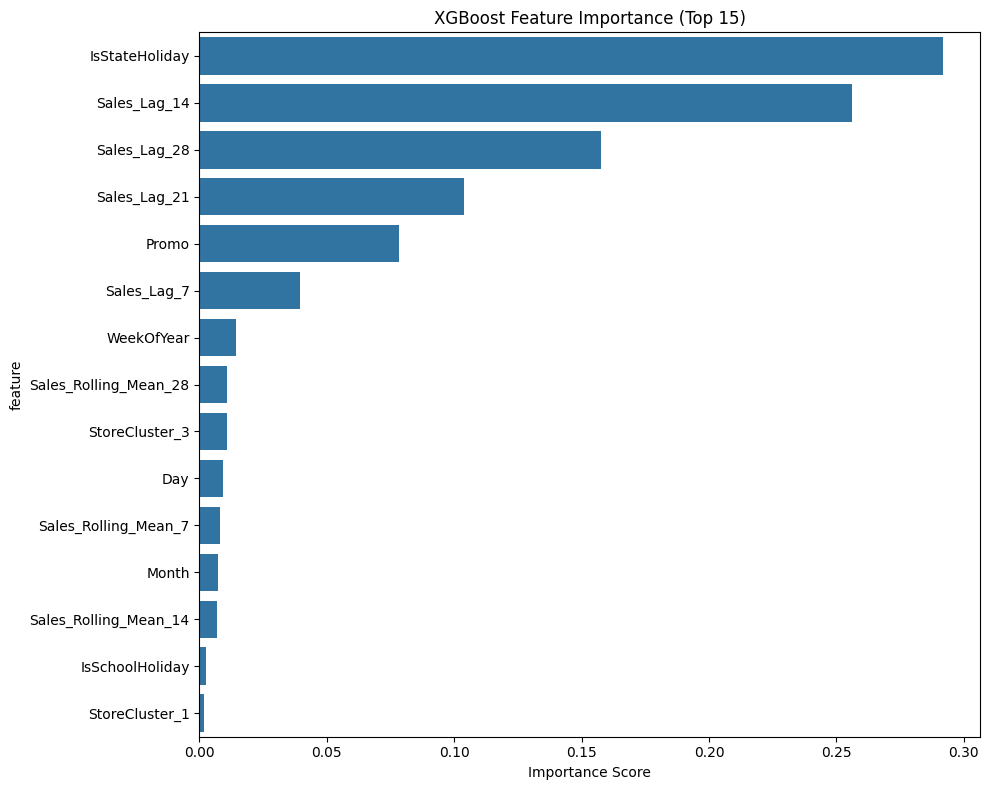

In [39]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('XGBoost Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

**Observation**:

* Sales from 14 days ago: is the strongest predictor of today’s sales. Strong bi-weekly pattern
 
* State holidays: have a huge impact on sales. Demand spikes or drops significantly. Stores behave very differently on holidays. Xgboost heavily relied to used this indicator in modeling.

* Sales_Lag_28: Sales from 28 days ago (≈ monthly pattern), Strong monthly seasonality.

* Promo: Promotions directly influence sales.

* Sales_Rolling_Mean_7/14/28: Capture smoothed trends. Useful but less precise than raw lag values. XGBoost prefers sharp signals.

* StoreCluster: These are having low score as this has an small effect and used as an indicator but time related features are more dominant while predicting sales.


## XGboost tuned

In [46]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer
import time

param_grid_ = {
    'n_estimators': [250, 500, 700],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.005, 0.007],
    'min_child_weight': [5,8, 10],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0.1,0.5],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0, 0.1, 0.3]
}

# Time series split
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"  Fold {fold + 1}: Train size = {len(train_idx):,}, Val size = {len(val_idx):,}")

rmspe_sklearn_scorer = make_scorer(rmspe, greater_is_better=False)

# Calculate total combinations for each grid
def count_combinations(param_grid):
    total = 1
    for key, values in param_grid.items():
        total *= len(values)
    return total

print("Parameter Grid Options:")
print(f" Grid: {count_combinations(param_grid_):,} combinations")

# Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid_,
#     scoring=rmspe_sklearn_scorer,  
#     cv=tscv,                       
#     verbose=2,                      
#     n_jobs=-1,                      
#     return_train_score=True,        
#     error_score='raise'             
# )


from sklearn.model_selection import RandomizedSearchCV

# 40 iterations * 5 folds = 200 fits
n_iter_search = 40 

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_, 
    n_iter=n_iter_search,
    scoring=rmspe_sklearn_scorer,
    cv=tscv,
    verbose=2,
    n_jobs=1, 
    random_state=42,
    return_train_score=True
)

start_time = time.time()
random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Randomized Search completed in {elapsed_time/60:.2f} minutes")
print(f"Best Params: {random_search.best_params_}")
# start_time = time.time()
# # Fit grid search
# grid_search.fit(X_train, y_train)

# # Calculate elapsed time
# elapsed_time = time.time() - start_time
# print(f"Grid Search completed in {elapsed_time/60:.2f} minutes")

  Fold 1: Train size = 146,864, Val size = 146,863
  Fold 2: Train size = 293,727, Val size = 146,863
  Fold 3: Train size = 440,590, Val size = 146,863
  Fold 4: Train size = 587,453, Val size = 146,863
  Fold 5: Train size = 734,316, Val size = 146,863
Parameter Grid Options:
 Grid: 5,832 combinations
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight=5, n_estimators=700, reg_alpha=0.3, reg_lambda=0.1, subsample=0.6; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight=5, n_estimators=700, reg_alpha=0.3, reg_lambda=0.1, subsample=0.6; total time=   8.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight=5, n_estimators=700, reg_alpha=0.3, reg_lambda=0.1, subsample=0.6; total time=  10.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight

In [47]:
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Best score (remember it's negative RMSPE due to sklearn scorer minimization)
best_rmspe = -random_search.best_score_
print(f"\n BEST CROSS-VALIDATION RMSPE: {best_rmspe:.4f}")

# Best estimator
xgb_model_reg = random_search.best_estimator_

  subsample: 0.8
  reg_lambda: 0.3
  reg_alpha: 0.1
  n_estimators: 700
  min_child_weight: 10
  max_depth: 8
  learning_rate: 0.007
  gamma: 0.5
  colsample_bytree: 0.6

 BEST CROSS-VALIDATION RMSPE: 0.1981


In [48]:
# # Regularized XGBoost Model

# xgb_model_reg = xgb.XGBRegressor(
#     n_estimators=1000,
#     learning_rate=0.05,
#     max_depth=7,
#     min_child_weight=10,      # Reduce overfitting
#     subsample=0.8,
#     colsample_bytree=0.8,
#     gamma=1,                   # Penalize weak splits
#     reg_alpha=1.0,             # L1 regularization
#     reg_lambda=1.0,            # L2 regularization
#     objective="reg:squarederror",
#     random_state=42,
#     eval_metric="rmse",
#     early_stopping_rounds=100,
#     n_jobs=-1
# )

# xgb_model_reg.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_val, y_val)],
#     verbose=100
# )

xgb_preds_reg = xgb_model_reg.predict(X_val)
xgb_rmse_reg = root_mean_squared_error(y_val, xgb_preds_reg)
xgb_rmspe_score_reg = rmspe(y_val, xgb_preds_reg)

print(f"Regularized XGBoost Results")
print(f"Validation RMSE: {xgb_rmse_reg:,.2f}")
print(f"Improvement: {xgb_rmse - xgb_rmse_reg:,.2f}")
print(f"Validation RMSPE: {xgb_rmspe_score_reg:,.2f}")
print(f"Improvement: {xgb_rmspe_score - xgb_rmspe_score_reg:,.2f}")

Regularized XGBoost Results
Validation RMSE: 1,043.76
Improvement: -37.44
Validation RMSPE: 0.14
Improvement: 0.00


# Prophet Modeling


## TRAIN/TEST SPLIT

Weekly patterns in retail are typically strong (weekends vs. weekdays)


In [49]:
df_prophet_train = store_prophet.copy()

# Define cutoff date (hold out last 48 days for testing)
train_cutoff = df_prophet_train['ds'].max() - pd.Timedelta(days=48)

prophet_train = df_prophet_train[df_prophet_train['ds'] <= train_cutoff].copy()
prophet_test = df_prophet_train[df_prophet_train['ds'] > train_cutoff].copy()


print("Train/Test Split")
print(f"Cutoff Date: {train_cutoff}")
print(f"Training Samples: {len(prophet_train):,}")
print(f"Test Samples: {len(prophet_test):,}")
print(f"Train Date Range: {prophet_train['ds'].min()} to {prophet_train['ds'].max()}")
print(f"Test Date Range: {prophet_test['ds'].min()} to {prophet_test['ds'].max()}")


# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # Daily data, so not needed
    seasonality_mode='multiplicative'  # Sales often has multiplicative patterns
)

# Add regressors
for reg in regressors:
    prophet_model.add_regressor(reg)
    
prophet_model.fit(prophet_train)


Train/Test Split
Cutoff Date: 2015-06-13 00:00:00
Training Samples: 894
Test Samples: 48
Train Date Range: 2013-01-01 00:00:00 to 2015-06-13 00:00:00
Test Date Range: 2015-06-14 00:00:00 to 2015-07-31 00:00:00


12:18:37 - cmdstanpy - INFO - Chain [1] start processing
12:18:37 - cmdstanpy - INFO - Chain [1] done processing


## Initialize Prophet model

### Create/Set Future Dataframe and predict

In [50]:
# Create future dataframe

# Predict future on test date
future = prophet_test[['ds'] + regressors].copy()

# # If wanted to predict the date beyond test date
# future = prophet_model.make_future_dataframe(periods=30)

# # Merge with regressor values
# future = future.merge(
#     prophet_train[["ds", "Promo", "IsStateHoliday", "IsSchoolHoliday"]],
#     on="ds",
#     how="left"
# ).fillna(0)

print("Future DataFrame (for prediction)")
print(f"Shape: {future.shape}")
print(f"Columns: {list(future.columns)}")
display(future.head())

# Generate predictions
forecast = prophet_model.predict(future)

print("Forecast is generated")
print(f"Forecast Shape: {forecast.shape}")
print(f"Key Columns: ds, yhat, yhat_lower, yhat_upper")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Merge forecast with actual test data
test_comparison = prophet_test.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)

print(f"Shape: {test_comparison.shape}")
display(test_comparison.head())


Future DataFrame (for prediction)
Shape: (48, 4)
Columns: ['ds', 'Promo', 'IsStateHoliday', 'IsSchoolHoliday']


,ds,Promo,IsStateHoliday,IsSchoolHoliday
0,2015-07-31,1,0,1
1115,2015-07-30,1,0,1
2230,2015-07-29,1,0,1
3345,2015-07-28,1,0,1
4460,2015-07-27,1,0,1


Forecast is generated
Forecast Shape: (48, 31)
Key Columns: ds, yhat, yhat_lower, yhat_upper


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-14,-26.528342,-786.794312,776.090813
1,2015-06-15,5510.951216,4688.421590,6220.187258
2,2015-06-16,5044.601937,4273.037022,5760.104125
3,2015-06-17,4925.952763,4215.701355,5704.643809
4,2015-06-18,4825.077370,4096.110571,5619.476294


Shape: (48, 9)


,ds,Store,y,Promo,IsStateHoliday,IsSchoolHoliday,yhat,yhat_lower,yhat_upper
0,2015-07-31,1,5263,1,0,1,4943.323895,4174.136164,5711.292697
1,2015-07-30,1,5020,1,0,1,4719.230009,3951.453262,5479.268025
2,2015-07-29,1,4782,1,0,1,4841.178278,4100.610785,5584.917189
3,2015-07-28,1,5011,1,0,1,4981.406058,4240.582675,5777.876994
4,2015-07-27,1,6102,1,0,1,5468.068497,4641.472778,6183.208498


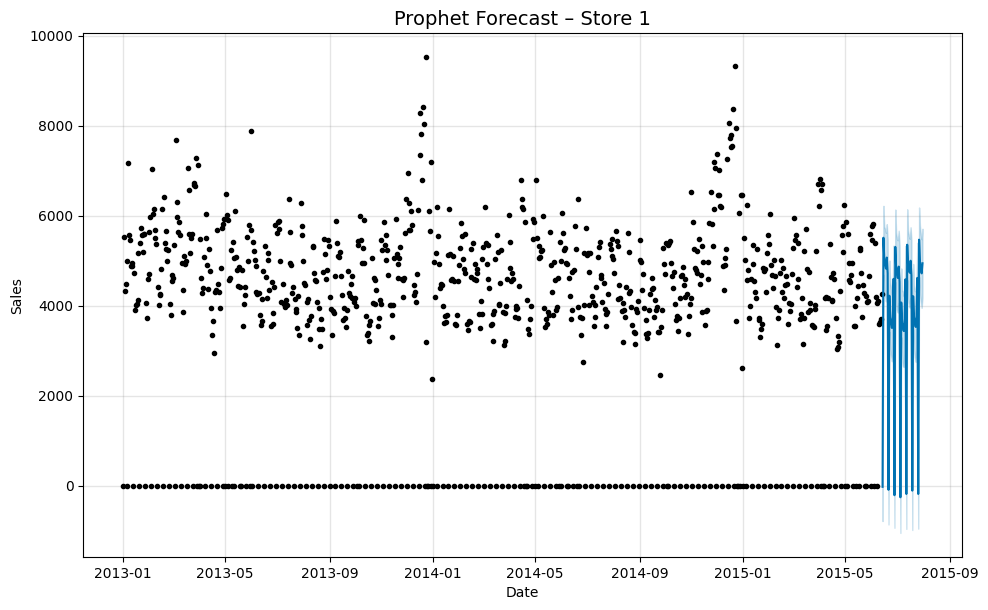

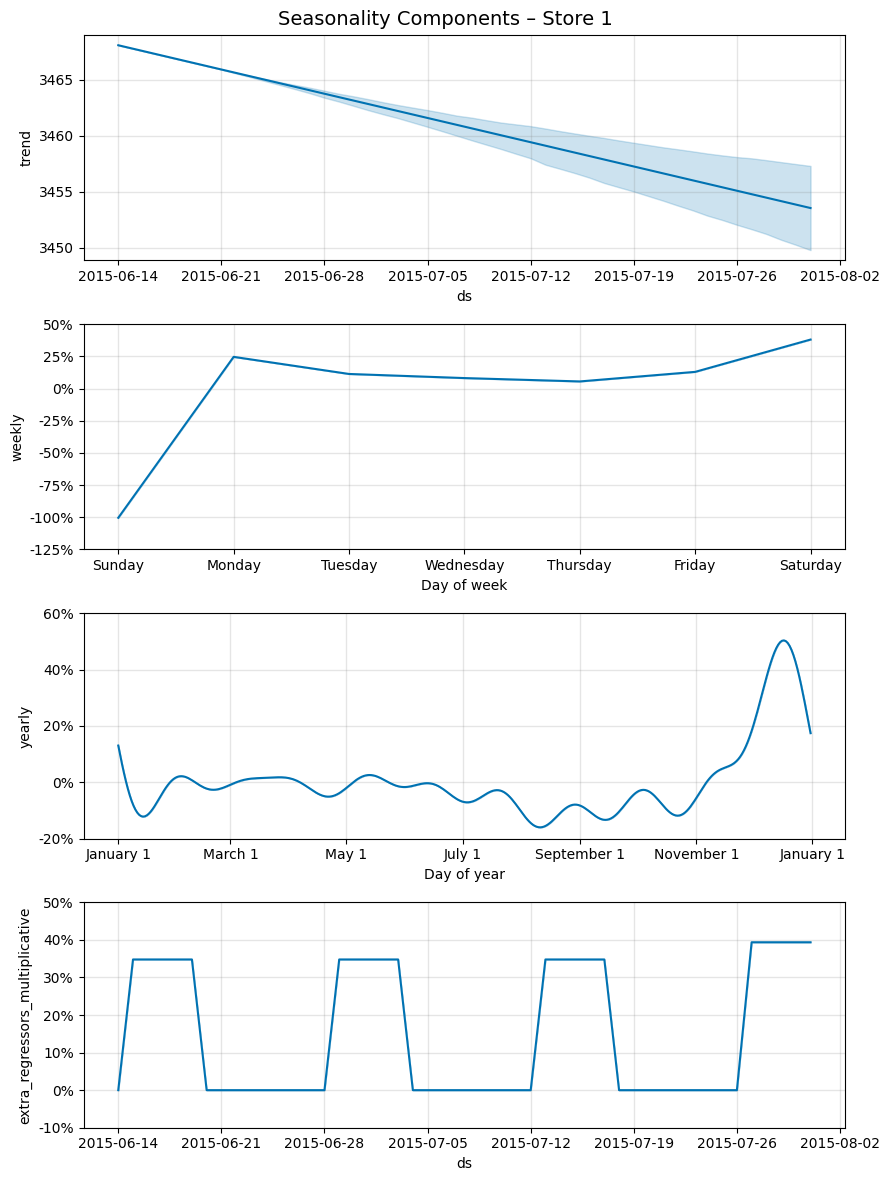

In [51]:
fig = prophet_model.plot(forecast)
plt.title(f"Prophet Forecast – Store {PROPHET_STORE_ID}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Plot components
fig = prophet_model.plot_components(forecast)
plt.suptitle(f"Seasonality Components – Store {PROPHET_STORE_ID}", fontsize=14)
plt.tight_layout()
plt.show()

In [52]:

# Calculate metrics
actual = test_comparison['y'].values
predicted = test_comparison['yhat'].values

# Ensure non-negative predictions
predicted = np.maximum(predicted, 0)

print("Data Quality Check")
print(f"NaN in actual: {np.isnan(actual).sum()}")
print(f"NaN in predicted: {np.isnan(predicted).sum()}")
print(f"Zeros in actual: {(actual == 0).sum()}")
print(f"Negative in predicted (before clip): {(test_comparison['yhat'].values < 0).sum()}")

# RMSPE
mask = actual > 0
rmspe_prophet = np.sqrt(np.mean(((actual[mask] - predicted[mask]) / actual[mask]) ** 2))

# Other metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

prophet_rmse = np.sqrt(mean_squared_error(actual, predicted))
prophet_rmspe = rmspe(actual, predicted)

print(f"Test RMSE: {prophet_rmse:,.2f}")
print(f"Test RMSPE: {prophet_rmspe:,.2f}")


Data Quality Check
NaN in actual: 0
NaN in predicted: 0
Zeros in actual: 7
Negative in predicted (before clip): 7
Test RMSE: 395.50
Test RMSPE: 0.10


Prophet is used for modeling single store at a time, for 1000+ stores we need to create 1000+ models for each store.

# LSTM Modeling

## LSTM dataset preparation for dataloader

In [53]:
class SalesDataset(Dataset):
    """Custom Dataset for sales prediction with cluster embeddings."""

    def __init__(self, X, y, cluster_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.cluster_ids = torch.tensor(cluster_ids, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.cluster_ids[idx], self.y[idx]

In [54]:
split_idx = int(len(X_lstm) * 0.8)

X_tr, X_va = X_lstm[:split_idx], X_lstm[split_idx:]
y_tr, y_va = y_lstm[:split_idx], y_lstm[split_idx:]
c_tr, c_va = cluster_ids[:split_idx], cluster_ids[split_idx:]

# Create datasets and loaders
train_ds = SalesDataset(X_tr, y_tr, c_tr)
val_ds = SalesDataset(X_va, y_va, c_va)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 9458
Validation batches: 2365


## LSTM Model Architecture

In [55]:
class LSTMWithClusterEmbedding(nn.Module):
    """
    LSTM model with store cluster embeddings.

    Architecture:
    1. LSTM processes temporal sequence
    2. Embedding layer encodes store cluster
    3. Combined features go through fully connected layers
    """

    def __init__(self, num_features, hidden_size, num_layers, num_clusters, embed_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        self.cluster_embedding = nn.Embedding(
            num_embeddings=num_clusters,
            embedding_dim=embed_dim
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, cluster_id):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        lstm_last = lstm_out[:, -1, :]  # Use last time step which has the encoded information about current and past event

        # Cluster embedding
        cluster_emb = self.cluster_embedding(cluster_id)

        # Concatenate and predict
        combined = torch.cat([lstm_last, cluster_emb], dim=1)
        out = self.fc(combined)

        return out.squeeze(1)

In [56]:
num_features = X_tr.shape[2]
num_clusters = int(cluster_ids.max() + 1)

lstm_model = LSTMWithClusterEmbedding(
    num_features=num_features,
    hidden_size=64,
    num_layers=2,
    num_clusters=num_clusters,
    embed_dim=4
).to(device)

# Optimizer config
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
GRADIENT_CLIP_VALUE = 1.0


print("LSTM Model Architecture")
print(lstm_model)
print(f"Total parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

LSTM Model Architecture
LSTMWithClusterEmbedding(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (cluster_embedding): Embedding(4, 4)
  (fc): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 58,257


## LSTM Model training

In [57]:
from tqdm import tqdm

EPOCHS = 15
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
EARLY_STOPPING_PATIENCE = 5
GRADIENT_CLIP_VALUE = 1.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_rmses = []
val_RMSPE = []

def train_one_epoch(model, train_loader, criterion, optimizer, device, curr_epoch):
    model.train()
    epoch_losses = []

    # Progress bar
    progress_bar = tqdm(train_loader, desc=f"Training Epoch: {curr_epoch +1}", leave = False, mininterval=15.0)

    for X_batch, c_batch, y_batch in progress_bar:
        X_batch = X_batch.to(device)     
        c_batch = c_batch.to(device)
        y_batch = y_batch.to(device)

        # Reset Zero gradient from previous batch
        optimizer.zero_grad()

        # Forward pass and make predictions
        predictions = model(X_batch, c_batch).squeeze(-1)

        # Calculate loss
        loss = criterion(predictions, y_batch)
        epoch_losses.append(loss.item())

        # Backward pass and update weights
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)

        # update weights
        optimizer.step()

        # Update progress bar
        if len(epoch_losses) % 100 == 0: 
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"}, refresh=False)

    return np.mean(epoch_losses)


def validate(model, val_loader, criterion, device):
    model.eval()
    val_losses = []
    all_preds = []
    all_true = []
    with torch.no_grad():
        for X_batch, c_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            c_batch = c_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch, c_batch).squeeze(-1)

            loss = criterion(predictions, y_batch)
            val_losses.append(loss.item())

            # Store predictions and true values
            all_preds.append(predictions.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
    
    # Flatten
    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)

    return np.mean(val_losses), np.array(all_preds), np.array(all_true)


def train_model(model, train_loader, val_loader, epochs, learning_rate, weight_decay, early_stopping_patience, gradient_clip_value, device):
    
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # History tracking
    history = {
        "train_loss": [],
        "val_loss": [],
        "lr": [],
        "val_rmse": [],
        "val_rmspe": []
    }

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
        val_loss, all_preds, all_true = validate(model, val_loader, criterion, device)

        # Calculate metrics
        val_rmse = np.sqrt(np.mean((all_preds - all_true) ** 2))
        val_rmspe = rmspe(all_preds, all_true)

        # Update learning rate
        scheduler.step(val_loss)
        curr_lr = optimizer.param_groups[0]['lr']

        # Update history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(curr_lr)
        history["val_rmse"].append(val_rmse)
        history["val_rmspe"].append(val_rmspe)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val RMSE {val_rmse:.4f} - Val RMSPE {val_rmspe:.4f}- LR: {curr_lr:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history


lstm_trainer = train_model(
    lstm_model,
    train_loader,
    val_loader,
    EPOCHS,
    LEARNING_RATE,
    WEIGHT_DECAY,
    EARLY_STOPPING_PATIENCE,
    GRADIENT_CLIP_VALUE,
    DEVICE
)



# Final LSTM Validation metrics
print(f"LSTM Final Results RMSE: {lstm_trainer['val_rmse'][-1]:.4f}")
print(f"LSTM Final Results RMSPE: {lstm_trainer['val_rmspe'][-1]:.4f}")

Epoch 1/15 - Train Loss: 0.0068 - Val Loss: 0.0045 - Val RMSE 0.0671 - Val RMSPE 0.1525- LR: 0.001000


Epoch 2/15 - Train Loss: 0.0038 - Val Loss: 0.0037 - Val RMSE 0.0612 - Val RMSPE 0.1398- LR: 0.001000


Epoch 3/15 - Train Loss: 0.0032 - Val Loss: 0.0036 - Val RMSE 0.0599 - Val RMSPE 0.1368- LR: 0.001000


Epoch 4/15 - Train Loss: 0.0029 - Val Loss: 0.0032 - Val RMSE 0.0569 - Val RMSPE 0.1307- LR: 0.001000


Epoch 5/15 - Train Loss: 0.0027 - Val Loss: 0.0030 - Val RMSE 0.0549 - Val RMSPE 0.1269- LR: 0.001000


Epoch 6/15 - Train Loss: 0.0026 - Val Loss: 0.0029 - Val RMSE 0.0536 - Val RMSPE 0.1237- LR: 0.001000


Epoch 7/15 - Train Loss: 0.0025 - Val Loss: 0.0032 - Val RMSE 0.0566 - Val RMSPE 0.1312- LR: 0.001000


Epoch 8/15 - Train Loss: 0.0024 - Val Loss: 0.0029 - Val RMSE 0.0538 - Val RMSPE 0.1234- LR: 0.001000


Epoch 9/15 - Train Loss: 0.0023 - Val Loss: 0.0032 - Val RMSE 0.0563 - Val RMSPE 0.1302- LR: 0.001000


Epoch 10/15 - Train Loss: 0.0023 - Val Loss: 0.0030 - Val RMSE 0.0548 - Val RMSPE 0.1275- LR: 0.000500


Epoch 11/15 - Train Loss: 0.0021 - Val Loss: 0.0028 - Val RMSE 0.0530 - Val RMSPE 0.1247- LR: 0.000500


Epoch 12/15 - Train Loss: 0.0021 - Val Loss: 0.0027 - Val RMSE 0.0523 - Val RMSPE 0.1220- LR: 0.000500


Epoch 13/15 - Train Loss: 0.0020 - Val Loss: 0.0028 - Val RMSE 0.0534 - Val RMSPE 0.1265- LR: 0.000500


Epoch 14/15 - Train Loss: 0.0020 - Val Loss: 0.0028 - Val RMSE 0.0534 - Val RMSPE 0.1266- LR: 0.000500


Epoch 15/15 - Train Loss: 0.0020 - Val Loss: 0.0028 - Val RMSE 0.0533 - Val RMSPE 0.1248- LR: 0.000500
LSTM Final Results RMSE: 0.0533
LSTM Final Results RMSPE: 0.1248


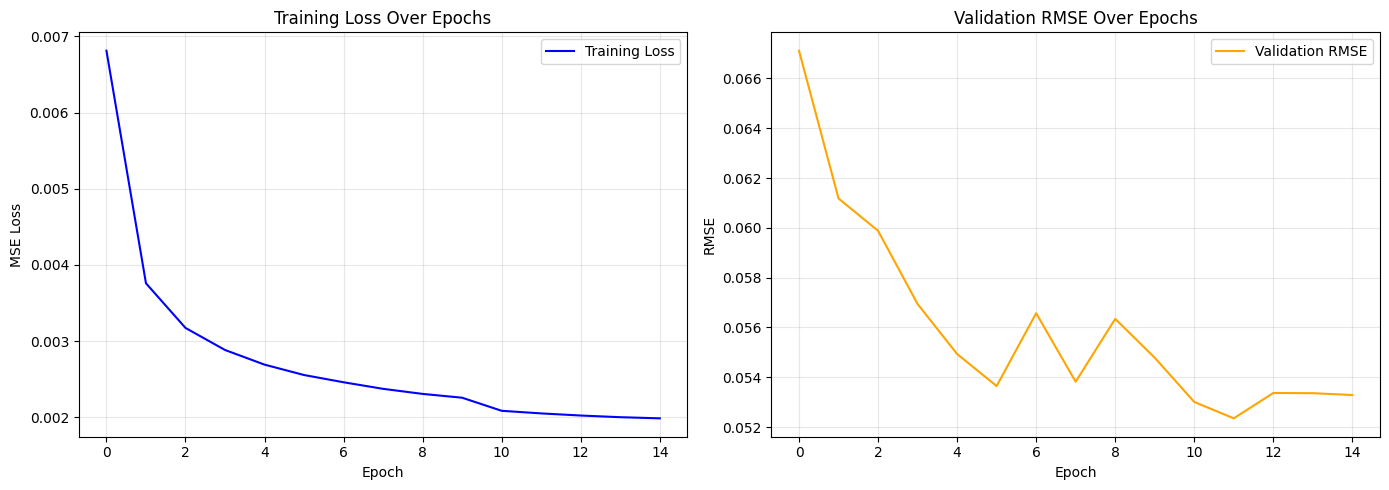

LSTM Final Results
Final Validation RMSE: 0.0533
Final Validation RMSPE: 0.1248


In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lstm_trainer["train_loss"], label='Training Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(lstm_trainer['val_rmse'], label='Validation RMSE', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Validation RMSE Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"LSTM Final Results")
print(f"Final Validation RMSE: {lstm_trainer['val_rmse'][-1]:.4f}")
print(f"Final Validation RMSPE: {lstm_trainer['val_rmspe'][-1]:.4f}")

In [59]:
"""
Convert scaled predictions back to original sales values for interpretation.
"""

lstm_model.eval()
val_preds_scaled = []
val_true_scaled = []

with torch.no_grad():
    for X_batch, c_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        c_batch = c_batch.to(device)

        preds = lstm_model(X_batch, c_batch)
        val_preds_scaled.extend(preds.cpu().numpy())
        val_true_scaled.extend(y_batch.numpy())

val_preds_scaled = np.array(val_preds_scaled)
val_true_scaled = np.array(val_true_scaled)

print("Scaled Results")
print(f"Predictions range: {val_preds_scaled.min():.4f} to {val_preds_scaled.max():.4f}")
print(f"Actual range: {val_true_scaled.min():.4f} to {val_true_scaled.max():.4f}")
print(f"RMSE (Scaled 0-1): {root_mean_squared_error(val_true_scaled, val_preds_scaled):.4f}")
print(f"")

# Inverse Transform to Original Scale

# Use the sales scaler to inverse transform
val_preds_original = lstm_scaler.inverse_transform(
    val_preds_scaled.reshape(-1, 1)
).flatten()

val_true_original = lstm_scaler.inverse_transform(
    val_true_scaled.reshape(-1, 1)
).flatten()

print("Original Scale Results")
print(f"Predictions range: {val_preds_original.min():,.0f} to {val_preds_original.max():,.0f}")
print(f"Actual range: {val_true_original.min():,.0f} to {val_true_original.max():,.0f}")

# Calculate Interpretable Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# RMSE in original units (sales euros/dollars)
lstm_rmse_original = root_mean_squared_error(val_true_original, val_preds_original)
lstm_rmspe_original = rmspe(val_true_original, val_preds_original)

# MAE - Average prediction error in sales units
lstm_mae_original = mean_absolute_error(val_true_original, val_preds_original)

# R² Score - Proportion of variance explained
lstm_r2 = r2_score(val_true_original, val_preds_original)


print(f"LSTM Final Results")
print(f"RMSE (Root Mean Square Error):{lstm_rmse_original:>10,.2f} sales units")
print(f"RMSPE (Root Mean Square Error): {lstm_rmspe_original:>10,.2f}")
print(f"R² Score:                      {lstm_r2:>10.4f}")

Scaled Results
Predictions range: 0.1340 to 0.9303
Actual range: 0.0000 to 1.0000
RMSE (Scaled 0-1): 0.0533

Original Scale Results
Predictions range: 2,219 to 15,401
Actual range: 0 to 16,554
LSTM Final Results
RMSE (Root Mean Square Error):    882.09 sales units
RMSPE (Root Mean Square Error):       0.26
R² Score:                          0.8599


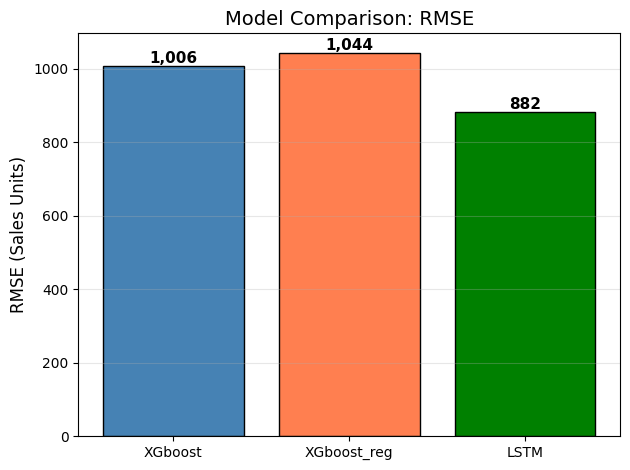

In [60]:
import matplotlib.pyplot as plt

models = ['XGboost', 'XGboost_reg', 'LSTM']
rmse_values = [xgb_rmse, xgb_rmse_reg, lstm_rmse_original]

colors = ['steelblue', 'coral', 'green']

bars = plt.bar(models, rmse_values, color=colors, edgecolor='black')

plt.ylabel('RMSE (Sales Units)', fontsize=12)
plt.title('Model Comparison: RMSE', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# labels on bars
for bar, val in zip(bars, rmse_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{val:,.0f}',
        ha='center', va='bottom',
        fontsize=11, fontweight='bold'
    )

plt.tight_layout()
plt.show()